In [ ]:
import warnings
import numpy as np
import pandas as pd
from sklearn.decomposition import TruncatedSVD
import lightgbm as lgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from nltk.corpus import stopwords

import nltk
nltk.download('stopwords')

russian_stop_words = stopwords.words('russian')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
data_dir_path = '/content/drive/MyDrive/ML Project/data/'
train_featured = pd.read_csv(data_dir_path + 'train_X_y_features_v1.csv')
test_featured = pd.read_csv( data_dir_path + 'test_X_y_features_v1.csv')
print(train_featured.shape)
print(test_featured.shape)

(1202739, 43)
(300685, 43)


In [ ]:
train_featured.columns

Index(['region', 'city', 'parent_category_name', 'category_name', 'param_1',
       'param_2', 'param_3', 'price', 'user_type', 'title', 'description',
       'region_city', 'all_category', 'category_param_1',
       'region_category_user', 'city_category_user', 'category_price_mean',
       'category_price_std', 'category_price_skew', 'city_price_mean',
       'city_price_max', 'city_price_skew', 'title_length',
       'description_length', 'title_word_count', 'description_word_count',
       'title_has_keyword', 'description_has_keyword', 'title_digit_count',
       'description_digit_count', 'description_newline_count', 'price_log',
       'price_bin', 'price_to_category_mean', 'price_to_category_max',
       'description_missing', 'item_id', 'user_id', 'item_seq_number',
       'activation_date', 'image', 'image_top_1', 'deal_probability'],
      dtype='object')

In [ ]:
# Tabluar features
train_X = train_featured.drop(['title','description', 'item_id', 'user_id', 'item_seq_number', 'activation_date', 'image',
       'image_top_1', 'deal_probability'], axis=1)
test_X = test_featured.drop(['title','description', 'item_id', 'user_id', 'item_seq_number', 'activation_date', 'image',
       'image_top_1', 'deal_probability'], axis=1)
train_y = train_featured['deal_probability']
test_y = test_featured['deal_probability']

In [ ]:
train_X.columns

Index(['region', 'city', 'parent_category_name', 'category_name', 'param_1',
       'param_2', 'param_3', 'price', 'user_type', 'region_city',
       'all_category', 'category_param_1', 'region_category_user',
       'city_category_user', 'category_price_mean', 'category_price_std',
       'category_price_skew', 'city_price_mean', 'city_price_max',
       'city_price_skew', 'title_length', 'description_length',
       'title_word_count', 'description_word_count', 'title_has_keyword',
       'description_has_keyword', 'title_digit_count',
       'description_digit_count', 'description_newline_count', 'price_log',
       'price_bin', 'price_to_category_mean', 'price_to_category_max',
       'description_missing'],
      dtype='object')

# Extract Embeddings

In [ ]:
# train
train_featured['title'] = train_featured['title'].fillna("")
train_featured['description'] = train_featured['description'].fillna("")
train_featured['text'] = train_featured['title'] + " " + train_featured['description']



In [ ]:
tfidf = TfidfVectorizer(
    max_features=500,
    stop_words= russian_stop_words)
tfidf_matrix = tfidf.fit_transform(train_featured['text'])


In [ ]:
print("TF-IDF matrix shape:", tfidf_matrix.shape)

TF-IDF matrix shape: (1202739, 500)


In [ ]:
# use SVD to reduce dimension
svd = TruncatedSVD(n_components=5, random_state=42)  # reduce dimension to 5d
svd_matrix = svd.fit_transform(tfidf_matrix)
print("SVD matrix shape:", svd_matrix.shape)

SVD matrix shape: (1202739, 5)


In [ ]:
tfidf_features = pd.DataFrame(svd_matrix, columns=[f'svd_{i}' for i in range(5)])
train_featured_with_tfidf = pd.concat([train_featured.reset_index(drop=True), tfidf_features], axis=1)
train_featured_with_tfidf.head()

,region,city,parent_category_name,category_name,param_1,param_2,param_3,price,user_type,title,...,activation_date,image,image_top_1,deal_probability,text,svd_0,svd_1,svd_2,svd_3,svd_4
0,Омская область,Омск,Бытовая электроника,Настольные компьютеры,NaN,NaN,NaN,50.0,Private,Продам системник,...,2017-03-28,5f1a4dc40d333d5cd20c9831553a61053e83ffb156f692...,2789.0,0.76786,Продам системник продам системник на запчасти.,0.426458,0.469653,-0.034854,-0.188869,0.071247
1,Башкортостан,Уфа,Хобби и отдых,Спорт и отдых,Зимние виды спорта,NaN,NaN,500.0,Private,Продам раздвижные коньки на девочку 32-36 разм,...,2017-03-16,659f553a15733bbc034bc2ea321a8aaa39feaa3fb1e410...,2645.0,0.00000,Продам раздвижные коньки на девочку 32-36 разм...,0.205034,0.184058,-0.002020,-0.046927,0.010675
2,Нижегородская область,Дзержинск,Для дома и дачи,Растения,NaN,NaN,NaN,80.0,Private,Ромашки и др,...,2017-03-16,7f5b347e054800f384d22a9959792ab6da7b1442931d03...,406.0,0.12311,Ромашки и др 1фото-ромашка крупноцветковая/\n2...,0.059681,-0.012399,0.014739,0.088000,-0.040258
3,Челябинская область,Миасс,Личные вещи,Детская одежда и обувь,Для девочек,Верхняя одежда,98-104 см (2-4 года),1500.0,Private,"Зимний комплект Bilemi p,98",...,2017-03-26,f17dae532061e4a29e25a44fbd90d40ae894c697d636d5...,94.0,0.80323,"Зимний комплект Bilemi p,98 Продам зимний кост...",0.226856,-0.037198,-0.069922,-0.064799,-0.013395
4,Башкортостан,Уфа,Для дома и дачи,Бытовая техника,Для кухни,Плиты,NaN,18990.0,Shop,Новая духовка Weissgauff самоочистка сенсор га...,...,2017-03-16,ef7789caae6b81233991c9485cf081bcd6530aa4bd9735...,1852.0,0.00000,Новая духовка Weissgauff самоочистка сенсор га...,0.108313,-0.029808,0.028333,0.140245,-0.118581


In [ ]:
train_featured_with_tfidf = train_featured_with_tfidf.drop(['title', 'description', 'text'], axis=1)
# train_featured_with_tfidf.to_csv(data_dir_path + 'train_embeddings_tfidf_svd.csv', index=False)


In [ ]:
# test
test_featured['title'] = test_featured['title'].fillna("")
test_featured['description'] = test_featured['description'].fillna("")
test_featured['text'] = test_featured['title'] + " " + test_featured['description']

tfidf = TfidfVectorizer(
    max_features=500,
    stop_words= russian_stop_words)
tfidf_matrix_test = tfidf.fit_transform(test_featured['text'])

In [ ]:

# use SVD to reduce dimension
svd = TruncatedSVD(n_components=5, random_state=42)  # reduce dimension to 5d
svd_matrix = svd.fit_transform(tfidf_matrix_test)
print("SVD matrix shape:", svd_matrix.shape)
tfidf_features = pd.DataFrame(svd_matrix, columns=[f'svd_{i}' for i in range(5)])




SVD matrix shape: (300685, 5)


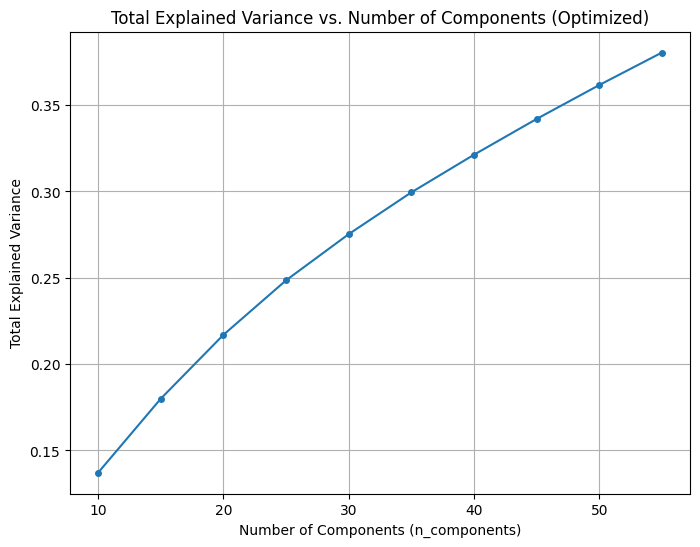

In [ ]:
explained_variances = []
n_components_range = range(10, 60, 5)
for n_components in n_components_range:
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    svd.fit(tfidf_matrix)
    explained_variances.append(svd.explained_variance_ratio_.sum())

plt.figure(figsize=(8, 6))
plt.plot(n_components_range, explained_variances, marker='o', linestyle='-', markersize=4)
plt.title("Total Explained Variance vs. Number of Components (Optimized)")
plt.xlabel("Number of Components (n_components)")
plt.ylabel("Total Explained Variance")
plt.grid(True)
plt.show()

In [ ]:
test_featured_with_tfidf = pd.concat([test_featured.reset_index(drop=True), tfidf_features], axis=1)
test_featured_with_tfidf.head()

,region,city,parent_category_name,category_name,param_1,param_2,param_3,price,user_type,title,...,activation_date,image,image_top_1,deal_probability,text,svd_0,svd_1,svd_2,svd_3,svd_4
0,Красноярский край,Красноярск,Личные вещи,"Одежда, обувь, аксессуары",Аксессуары,NaN,NaN,50000.0,Private,Сумка бренд Louis Vuitton,...,2017-03-19,3e6502f1657e3f256be696fd82feb455ddc82345e3577e...,256.0,0.0,"Сумка бренд Louis Vuitton Сумка коллекционная,...",0.183250,-0.150625,-0.140535,-0.037772,-0.014746
1,Ярославская область,Ярославль,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,21950.0,Company,Автокресло Carmate (Ailebebe) Swing Moon Beige,...,2017-03-18,9270dff29b16082e5a01d35a418cd6d525b6618c33fc58...,796.0,0.0,Автокресло Carmate (Ailebebe) Swing Moon Beige...,0.102642,-0.026940,0.000830,0.131964,-0.048938
2,Тюменская область,Тюмень,Личные вещи,"Одежда, обувь, аксессуары",Мужская одежда,Пиджаки и костюмы,52–54 (XXL),2500.0,Private,Пиджак кожанный,...,2017-03-19,bbe390ab0a1ed2cb97c4ed064524e9809825dfeba713c0...,655.0,0.0,"Пиджак кожанный Состояние на 4, торг",0.186076,-0.018780,0.054649,0.231072,-0.195388
3,Новосибирская область,Новосибирск,Личные вещи,Детская одежда и обувь,Для девочек,Обувь,32,750.0,Company,Сапоги на слякоть котофей нов,...,2017-03-20,e528c5df69dbc8d6073e9b617b174bec2405cf7e6e3689...,91.0,0.0,Сапоги на слякоть котофей нов Сапожки из невес...,0.063535,-0.010225,0.000436,0.074031,-0.051945
4,Краснодарский край,Новороссийск,Личные вещи,"Одежда, обувь, аксессуары",Женская одежда,Платья и юбки,42–44 (S),200.0,Private,Юбка,...,2017-03-19,ce15238bc8d1d093b79ade25f1346be1acfc7d9570ec1b...,81.0,0.0,"Юбка Юбка женская, размер 42-44, цвет черный, ...",0.194431,-0.157453,-0.049707,0.006616,-0.085714


In [ ]:
# test_featured_with_tfidf.to_csv(data_dir_path + 'test_embeddings_tfidf_svd.csv', index=False)


In [ ]:
def fit_lgb(
        train_X, train_y, test_X, test_y, categorical_features,
        params=None,
        num_boost_round=1000,
        early_stopping_rounds=50,
        eval_period=20,
    ):

    if params is None:
        params = {
            'objective': 'regression',
            'metric': 'rmse',
            'boosting_type': 'gbdt',
            'learning_rate': 0.02,
            'num_leaves': 512,
            'max_depth': 20,

            'bagging_seed': 42,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'feature_fraction': 0.8,
            'lambda_l1': 2.25,
            'lambda_l2': 0.015,

            'verbose': -1
        }

    # label encoding for cat var
    for col in categorical_features:
        train_X[col] = train_X[col].astype('category')
        test_X[col] = test_X[col].astype('category')

    # validation set for early stopping
    train_X_split, val_X_split, train_y_split, val_y_split = train_test_split(
        train_X, train_y, test_size=0.2, random_state=42, shuffle=True
    )
    lgb_train = lgb.Dataset(
        train_X_split, label=train_y_split, categorical_feature=categorical_features
    )
    lgb_val = lgb.Dataset(
        val_X_split, label=val_y_split, categorical_feature=categorical_features,
        reference=lgb_train
    )

    callbacks = [
        lgb.early_stopping(stopping_rounds=early_stopping_rounds),
        lgb.log_evaluation(period=eval_period)
    ]

    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=num_boost_round,
        valid_sets=[lgb_train, lgb_val],
        callbacks=callbacks
    )

    preds = model.predict(test_X, num_iteration=model.best_iteration)
    rmse = mean_squared_error(test_y, preds, squared=False)
    print(f"RMSE: {rmse}")

    return model

# Fit LightGBM - Embeddings(500)


In [ ]:
model_onlyembeddings = fit_lgb(tfidf_matrix, train_y, tfidf_matrix_test, test_y, [])


Training until validation scores don't improve for 50 rounds
[20]	training's rmse: 0.253341	valid_1's rmse: 0.254982
[40]	training's rmse: 0.249627	valid_1's rmse: 0.251575
[60]	training's rmse: 0.247221	valid_1's rmse: 0.249447
[80]	training's rmse: 0.245499	valid_1's rmse: 0.247981
[100]	training's rmse: 0.244151	valid_1's rmse: 0.246881
[120]	training's rmse: 0.243081	valid_1's rmse: 0.246027
[140]	training's rmse: 0.242194	valid_1's rmse: 0.245351
[160]	training's rmse: 0.241442	valid_1's rmse: 0.244808
[180]	training's rmse: 0.240767	valid_1's rmse: 0.244343
[200]	training's rmse: 0.240188	valid_1's rmse: 0.243963
[220]	training's rmse: 0.239675	valid_1's rmse: 0.243632
[240]	training's rmse: 0.239222	valid_1's rmse: 0.243358
[260]	training's rmse: 0.238773	valid_1's rmse: 0.243105
[280]	training's rmse: 0.238403	valid_1's rmse: 0.24289
[300]	training's rmse: 0.238068	valid_1's rmse: 0.242705
[320]	training's rmse: 0.237749	valid_1's rmse: 0.242538
[340]	training's rmse: 0.237477	

# Fit LightGBM - Embeddings+ 5D SVD only





In [ ]:
train_X_svds = train_featured_with_tfidf[[f'svd_{i}' for i in range(5)]]
test_X_svds = test_featured_with_tfidf[[f'svd_{i}' for i in range(5)]]
train_y = train_featured_with_tfidf['deal_probability']
test_y = test_featured_with_tfidf['deal_probability']

In [ ]:
model = fit_lgb(train_X_svds, train_y, test_X_svds, test_y, [])

Training until validation scores don't improve for 50 rounds
[20]	training's rmse: 0.254225	valid_1's rmse: 0.255809
[40]	training's rmse: 0.251207	valid_1's rmse: 0.253055
[60]	training's rmse: 0.249496	valid_1's rmse: 0.25161
[80]	training's rmse: 0.248416	valid_1's rmse: 0.250769
[100]	training's rmse: 0.247693	valid_1's rmse: 0.2503
[120]	training's rmse: 0.247169	valid_1's rmse: 0.250029
[140]	training's rmse: 0.246735	valid_1's rmse: 0.249843
[160]	training's rmse: 0.246374	valid_1's rmse: 0.249732
[180]	training's rmse: 0.246047	valid_1's rmse: 0.24965
[200]	training's rmse: 0.245749	valid_1's rmse: 0.249584
[220]	training's rmse: 0.245475	valid_1's rmse: 0.249536
[240]	training's rmse: 0.24522	valid_1's rmse: 0.249494
[260]	training's rmse: 0.24498	valid_1's rmse: 0.24947
[280]	training's rmse: 0.244761	valid_1's rmse: 0.249453
[300]	training's rmse: 0.244544	valid_1's rmse: 0.24944
[320]	training's rmse: 0.244326	valid_1's rmse: 0.24942
[340]	training's rmse: 0.244109	valid_1'

# Fit LightGBM - Embeddings+Tabular

In [ ]:
train_featured_with_tfidf.columns

Index(['region', 'city', 'parent_category_name', 'category_name', 'param_1',
       'param_2', 'param_3', 'price', 'user_type', 'region_city',
       'all_category', 'category_param_1', 'region_category_user',
       'city_category_user', 'category_price_mean', 'category_price_std',
       'category_price_skew', 'city_price_mean', 'city_price_max',
       'city_price_skew', 'title_length', 'description_length',
       'title_word_count', 'description_word_count', 'title_has_keyword',
       'description_has_keyword', 'title_digit_count',
       'description_digit_count', 'description_newline_count', 'price_log',
       'price_bin', 'price_to_category_mean', 'price_to_category_max',
       'description_missing', 'item_id', 'user_id', 'item_seq_number',
       'activation_date', 'image', 'image_top_1', 'deal_probability', 'svd_0',
       'svd_1', 'svd_2', 'svd_3', 'svd_4'],
      dtype='object')

In [ ]:
test_featured_with_tfidf.columns

Index(['region', 'city', 'parent_category_name', 'category_name', 'param_1',
       'param_2', 'param_3', 'price', 'user_type', 'title', 'description',
       'region_city', 'all_category', 'category_param_1',
       'region_category_user', 'city_category_user', 'category_price_mean',
       'category_price_std', 'category_price_skew', 'city_price_mean',
       'city_price_max', 'city_price_skew', 'title_length',
       'description_length', 'title_word_count', 'description_word_count',
       'title_has_keyword', 'description_has_keyword', 'title_digit_count',
       'description_digit_count', 'description_newline_count', 'price_log',
       'price_bin', 'price_to_category_mean', 'price_to_category_max',
       'description_missing', 'item_id', 'user_id', 'item_seq_number',
       'activation_date', 'image', 'image_top_1', 'deal_probability', 'text',
       'svd_0', 'svd_1', 'svd_2', 'svd_3', 'svd_4'],
      dtype='object')

In [ ]:
train_X_svd_tabular = train_featured_with_tfidf.drop(['deal_probability','item_id','user_id','item_seq_number','activation_date','image','image_top_1'], axis=1)
test_X_svd_tabular = test_featured_with_tfidf.drop(['deal_probability','text','title','description','item_id','user_id','item_seq_number','activation_date','image','image_top_1'], axis=1)
train_y = train_featured_with_tfidf['deal_probability']
test_y = test_featured_with_tfidf['deal_probability']


In [ ]:
categorical_features = [
    'region', 'city', 'parent_category_name',
    'category_name', 'param_1', 'param_2','param_3', 'user_type',
    'region_city', 'all_category','category_param_1', 'region_category_user', 'city_category_user',
    'title_has_keyword', 'description_has_keyword',
    'price_bin', 'description_missing'
]


In [ ]:
model_2 = fit_lgb(train_X_svd_tabular, train_y, test_X_svd_tabular, test_y, categorical_features)


Training until validation scores don't improve for 50 rounds
[20]	training's rmse: 0.242297	valid_1's rmse: 0.245197
[40]	training's rmse: 0.232743	valid_1's rmse: 0.237269
[60]	training's rmse: 0.227247	valid_1's rmse: 0.233332
[80]	training's rmse: 0.223758	valid_1's rmse: 0.23131
[100]	training's rmse: 0.22129	valid_1's rmse: 0.230239
[120]	training's rmse: 0.2195	valid_1's rmse: 0.229654
[140]	training's rmse: 0.218067	valid_1's rmse: 0.229335
[160]	training's rmse: 0.216917	valid_1's rmse: 0.229158
[180]	training's rmse: 0.216006	valid_1's rmse: 0.229054
[200]	training's rmse: 0.215343	valid_1's rmse: 0.229006
[220]	training's rmse: 0.214841	valid_1's rmse: 0.228972
[240]	training's rmse: 0.21441	valid_1's rmse: 0.228936
[260]	training's rmse: 0.214083	valid_1's rmse: 0.228931
[280]	training's rmse: 0.213752	valid_1's rmse: 0.228922
[300]	training's rmse: 0.213417	valid_1's rmse: 0.22891
[320]	training's rmse: 0.213164	valid_1's rmse: 0.228911
[340]	training's rmse: 0.212933	valid

In [ ]:
feature_importances = pd.DataFrame({
    'feature': model_2.feature_name(),
    'importance': model_2.feature_importance()
}).sort_values(by='importance', ascending=False)

print(feature_importances)

                      feature  importance
12       region_category_user       18417
13         city_category_user       17873
31     price_to_category_mean       10648
7                       price       10412
1                        city        9989
21         description_length        9887
34                      svd_0        8175
20               title_length        7903
35                      svd_1        7725
36                      svd_2        6798
38                      svd_4        6649
32      price_to_category_max        6646
37                      svd_3        6090
11           category_param_1        5657
23     description_word_count        5632
4                     param_1        5051
9                 region_city        3719
27    description_digit_count        3528
5                     param_2        3458
6                     param_3        2626
29                  price_log        2574
19            city_price_skew        2164
28  description_newline_count     